# Segmentation of Cell Nucleus

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/35_Nuclear_segmentation/"
%cd gdrive/My Drive/35_Nuclear_segmentation/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/35_Nuclear_segmentation


## Importing Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

## Loading Train Files

In [0]:
IMAGE_HEIGHT = IMAGE_WIDTH = 128
NUM_CHANNELS = 3
TRAIN_PATH = "./Data/train/"
TEST_PATH = "./Data/validation/"

In [0]:
from tqdm import tqdm_notebook

def load_images(Path, is_train = True):
  images = []
  masks = []
  train_files = next(os.walk(Path))[1]
  for n, filename in tqdm_notebook(enumerate(train_files), total = len(train_files)):
    
    image_path = Path + filename + '/images/' + filename + '.png'
    image = cv2.imread(image_path)[:,:,:NUM_CHANNELS]
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_AREA)
    images.append(image)
 
    if(is_train):

      combined_mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1))

      mask_path = Path + filename + '/masks/'
      for mask_file in next(os.walk(mask_path))[2]:
        mask = cv2.imread(mask_path + mask_file)
        mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_AREA)
        mask = np.expand_dims(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY), axis=-1)
          
        combined_mask = np.maximum(combined_mask, mask)
    

      masks.append(combined_mask)

  if (is_train): return np.array(images),np.array(masks)
  else: return np.array(images)

train_images,train_masks = load_images(TRAIN_PATH)


## Pickling train data

In [0]:
'''
with open('./Data/train_data.pickle', 'wb') as file:
  pickle.dump(train_images, file)
with open('./Data/train_masks.pickle', 'wb') as file:
  pickle.dump(train_masks, file)
'''

"\nwith open('./train_data', 'wb') as file:\n  pickle.dump(train_images, file)\nwith open('./train_masks', 'wb') as file:\n  pickle.dump(train_masks, file)\n"

In [0]:
import pickle

with open('./Data/train_data.pickle', 'rb') as infile:
  train_images = pickle.load(infile)

with open('./Data/train_lables.pickle', 'rb') as infile:
  train_masks = pickle.load(infile)


In [0]:
print(train_images.shape, train_masks.shape)

(670, 128, 128, 3) (670, 128, 128, 1)


## Displaying few Samples

In [0]:
with open('./train_data', 'rb') as file:
  train_data = pickle.load(file ,encoding='latin1')
with open('./train_masks', 'rb') as file:
  train_labels = pickle.load(file ,encoding='latin1')

In [0]:
print(train_data.shape, train_labels.shape)

(670, 128, 128, 3) (670, 128, 128, 1)


## Defining IOU Metric

In [0]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator

In [0]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [0]:
def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

## Defining Our Model

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers

In [0]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2

### HYPER_PARAMETERS

In [0]:
EPOCHS = 100
LEARNING_RATE = 0.00001
BATCH_SIZE = 16

### Compiling the model

In [0]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=[my_iou_metric])

### Initializing Callbacks

In [0]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import keras

In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://ee316f58.ngrok.io


In [0]:
model_path = "./Models/nuclei_finder_gpu_checkpoint.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)



In [0]:
history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, TensorBoardColabCallback(tbc)]
                       )

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 116s 192ms/step - loss: 0.1015 - my_iou_metric: 0.4920 - val_loss: 0.1107 - val_my_iou_metric: 0.5092

Epoch 00001: val_loss did not improve from 0.10930
Epoch 2/100
603/603 [==============================] - 114s 189ms/step - loss: 0.0967 - my_iou_metric: 0.5029 - val_loss: 0.1112 - val_my_iou_metric: 0.4971

Epoch 00002: val_loss did not improve from 0.10930
Epoch 3/100
603/603 [==============================] - 114s 189ms/step - loss: 0.0917 - my_iou_metric: 0.5145 - val_loss: 0.1100 - val_my_iou_metric: 0.4827

Epoch 00003: val_loss did not improve from 0.10930
Epoch 4/100
603/603 [==============================] - 113s 188ms/step - loss: 0.0901 - my_iou_metric: 0.5210 - val_loss: 0.1161 - val_my_iou_metric: 0.5021

Epoch 00004: val_loss did not improve from 0.10930
Epoch 5/100
603/603 [==============================] - 113s 187ms/step - loss: 0.0861 - my_iou_metric: 0.5382 - val_los

## Testing our Model

In [0]:
with open('./Data/test_data.pickle', 'rb') as infile:
  X_test = pickle.load(infile)
print("Number of elements in the test set: {}".format(len(X_test)))

Number of elements in the test set: 65


In [0]:
#model = load_model('/home/deeplearningcv/DeepLearningCV/Trained Models/nuclei_finder_unet_2.h5', 
                   #custom_objects={'my_iou_metric': my_iou_metric})


predictions = model.predict(train_data, verbose=1)
predicton_threshold = (predictions > 0.5).astype(np.uint8)

670/670 [==============================] - 29s 44ms/step


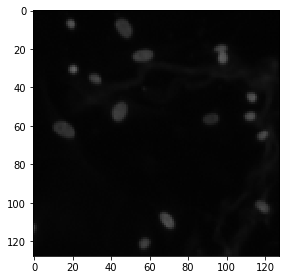

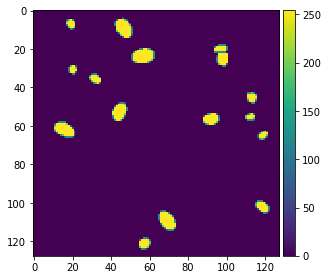

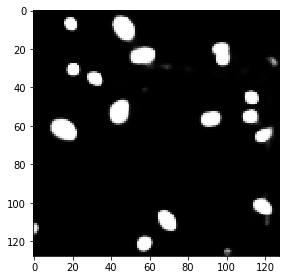

In [0]:
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt

ix = random.randint(0, len(predictions))
imshow(train_data[ix])
plt.show()
imshow(np.squeeze(train_labels[ix]))
plt.show()
imshow(np.squeeze(predictions[ix]))
plt.show()

In [0]:
predictions = model.predict(X_test, verbose=1)
predicton_threshold = (predictions > 0.5).astype(np.uint8)

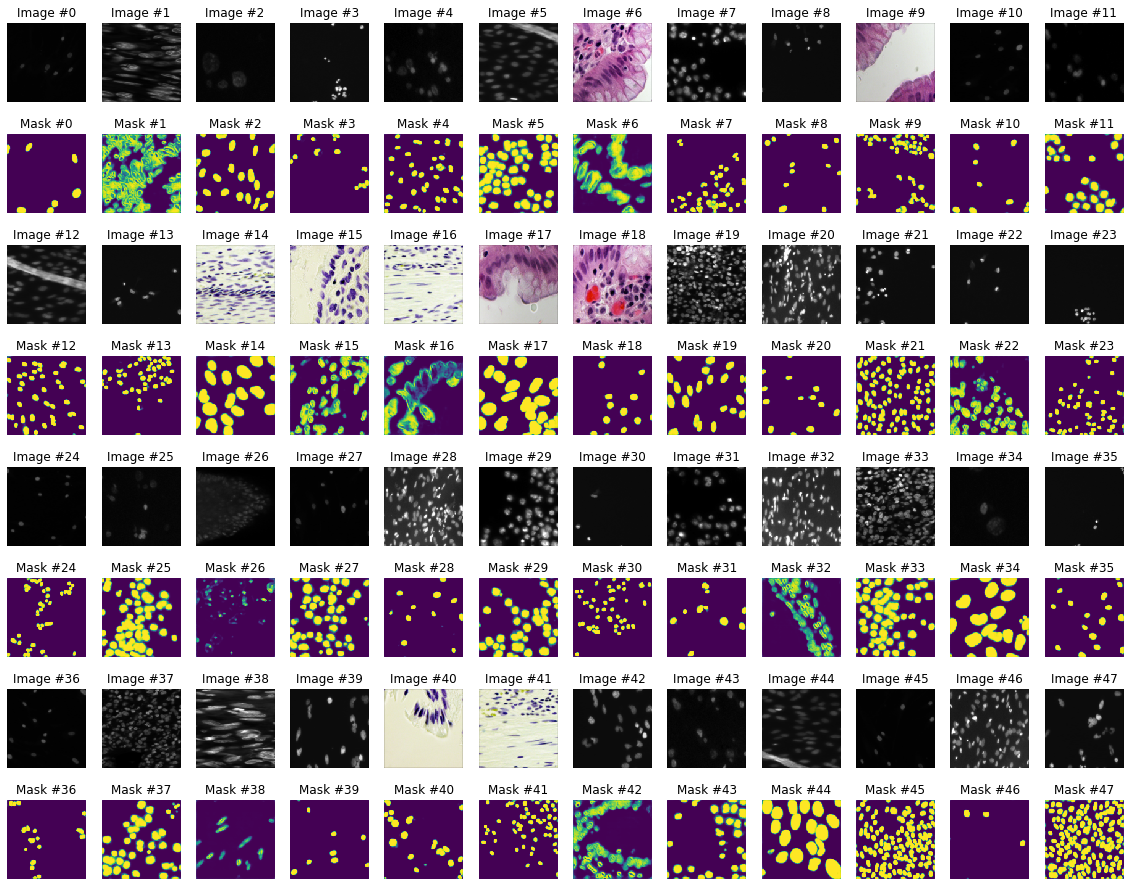

In [0]:
plt.figure(figsize=(20,16))
x, y = 12,4
pos = 0
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
       
        plt.imshow(X_test[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(predictions[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')

        pos += 1
        
plt.show()